In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facebook-ego/698.featnames
/kaggle/input/facebook-ego/3980.featnames
/kaggle/input/facebook-ego/686.egofeat
/kaggle/input/facebook-ego/3437.circles
/kaggle/input/facebook-ego/1912.featnames
/kaggle/input/facebook-ego/1684.featnames
/kaggle/input/facebook-ego/1684.egofeat
/kaggle/input/facebook-ego/3437.feat
/kaggle/input/facebook-ego/3437.featnames
/kaggle/input/facebook-ego/686.circles
/kaggle/input/facebook-ego/107.featnames
/kaggle/input/facebook-ego/348.egofeat
/kaggle/input/facebook-ego/0.feat
/kaggle/input/facebook-ego/698.feat
/kaggle/input/facebook-ego/686.feat
/kaggle/input/facebook-ego/107.feat
/kaggle/input/facebook-ego/348.feat
/kaggle/input/facebook-ego/698.circles
/kaggle/input/facebook-ego/0.circles
/kaggle/input/facebook-ego/414.edges
/kaggle/input/facebook-ego/414.feat
/kaggle/input/facebook-ego/1684.feat
/kaggle/input/facebook-ego/698.egofeat
/kaggle/input/facebook-ego/414.circles
/kaggle/input/facebook-ego/1912.edges
/kaggle/input/facebook-ego/1684.edge

In [54]:
# ===== CONFIG =====
EDGES_PATH  = "/kaggle/input/facebook-combined/facebook_combined.txt"
LABELS_PATH = None   #

NODE_TARGET   = 414
TOPK          = 10
POS_FRAC_HIDE = 0.10   # 
NEG_RATIO     = 1.0    # 
SEED          = 42

# ===== IMPORTS =====
import os, math, gc
import numpy as np, pandas as pd, networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

np.random.seed(SEED)


In [55]:
def load_graph(path: str) -> nx.Graph:
    G = nx.Graph()
    with open(path, "r") as f:
        for line in f:
            u, v = map(int, line.split())
            G.add_edge(u, v)
    return G

G = load_graph(EDGES_PATH)
print("Nodes:", G.number_of_nodes(), "| Edges:", G.number_of_edges(), "| Directed?", G.is_directed())


Nodes: 4039 | Edges: 88234 | Directed? False


In [56]:
# ==== LOAD GRAPH ====
import pandas as pd
import networkx as nx

# đọc danh sách cạnh
edges = pd.read_csv(EDGES_PATH, sep=" ", header=None, names=["u", "v"])
G = nx.from_pandas_edgelist(edges, "u", "v")

print(f"Số node: {G.number_of_nodes()}, số cạnh: {G.number_of_edges()}")

# ==== TẠO CẶP (NODE_TARGET, hàng xóm ngẫu nhiên) ====

neighbors = list(G.nodes())
pairs = [(NODE_TARGET, v) for v in neighbors if v != NODE_TARGET]

# ==== HÀM TRÍCH ĐẶC TRƯNG ====
def features_for_pairs_table(G: nx.Graph, pairs):
    pairs = [(int(u), int(v)) for (u,v) in pairs if u in G and v in G and u!=v]

    cn = {(u,v): sum(1 for _ in nx.common_neighbors(G, u, v)) for (u,v) in pairs}
    jacc = {(u,v): s for (u,v,s) in nx.jaccard_coefficient(G, pairs)}
    aa = {(u,v): s for (u,v,s) in nx.adamic_adar_index(G, pairs)}
    pa = {(u,v): s for (u,v,s) in nx.preferential_attachment(G, pairs)}

    spl = {}
    for (u,v) in pairs:
        try: spl[(u,v)] = nx.shortest_path_length(G, u, v)
        except: spl[(u,v)] = 99

    rows = []
    for (u,v) in pairs:
        rows.append({
            "u": u, "v": v,
            "cn": cn.get((u,v), 0),
            "jaccard": jacc.get((u,v), 0.0),
            "adamic_adar": aa.get((u,v), 0.0),
            "pref_attach": pa.get((u,v), 0),
            "sp_len": spl.get((u,v), 99),
        })
    df = pd.DataFrame(rows)
    return df

# ==== GỌI HÀM CHO NODE_TARGET ====
df_features = features_for_pairs_table(G, pairs)

# In ra 10 hàng đầu tiên, sắp theo số bạn chung (cn)
df_features.sort_values("cn", ascending=False).head(10)


Số node: 4039, số cạnh: 88234


,u,v,cn,jaccard,adamic_adar,pref_attach,sp_len
361,414,376,57,0.242553,15.739738,21147,1
1537,414,373,53,0.265000,13.242266,14946,1
1662,414,513,49,0.246231,12.392075,14151,1
349,414,428,48,0.212389,13.208676,18285,1
365,414,483,47,0.137026,11.647372,36729,1
1704,414,559,45,0.228426,10.795253,13197,1
1715,414,591,45,0.281250,11.288379,7314,1
348,414,348,45,0.131195,11.633520,36411,1
364,414,475,44,0.185654,10.398301,19398,1
1592,414,436,44,0.251429,11.709179,9540,1


In [57]:
def build_supervised_dataset(G: nx.Graph, labels_path: str = None,
                             pos_frac_hide=0.1, neg_ratio=1.0, seed=42):
    """
    - Có labels.csv (u,v,label) -> dùng trực tiếp, trích đặc trưng trên G hiện tại.
    - Không có -> ẩn một phần edges làm positive, sample non-edges làm negative,
      trích đặc trưng trên G đã bỏ positive để tránh rò rỉ.
    Trả về (X, y, G_feat) với G_feat là đồ thị dùng trích feature.
    """
    rng = np.random.default_rng(seed)

    if labels_path and os.path.exists(labels_path):
        df_lab = pd.read_csv(labels_path)
        assert set(["u","v","label"]).issubset(df_lab.columns), "labels.csv cần cột u,v,label"
        pairs = list(zip(df_lab["u"].astype(int), df_lab["v"].astype(int)))
        X = features_for_pairs_table(G, pairs)
        X["label"] = df_lab["label"].astype(int).values
        return X.drop(columns=["u","v"]), X["label"], G

    # --- Tự tạo nhãn ---
    edges = list(G.edges()); rng.shuffle(edges)
    m_hide = max(1, int(pos_frac_hide * len(edges)))
    pos_edges = edges[:m_hide]

    G_feat = G.copy()
    G_feat.remove_edges_from(pos_edges)  # tránh leakage

    # Negative = non-edges (cùng số lượng positive)
    target_neg = int(neg_ratio * m_hide)
    neg_edges, nodes = set(), list(G_feat.nodes())
    while len(neg_edges) < target_neg:
        u, v = rng.choice(nodes, 2, replace=False)
        if not G_feat.has_edge(u, v):
            neg_edges.add((int(u), int(v)))
    neg_edges = list(neg_edges)

    df_pos = features_for_pairs_table(G_feat, pos_edges); df_pos["label"] = 1
    df_neg = features_for_pairs_table(G_feat, neg_edges); df_neg["label"] = 0
    df_all = pd.concat([df_pos, df_neg], ignore_index=True)

    X = df_all.drop(columns=["u","v","label"])
    y = df_all["label"].astype(int)
    return X, y, G_feat

X, y, G_feat_graph = build_supervised_dataset(
    G, LABELS_PATH, pos_frac_hide=POS_FRAC_HIDE, neg_ratio=NEG_RATIO, seed=SEED
)
print("Supervised dataset:", X.shape, "| positives:", int(y.sum()), "| negatives:", int((1-y).sum()))


Supervised dataset: (17646, 5) | positives: 8823 | negatives: 8823


In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

rf = RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=SEED)
rf.fit(X_train, y_train)

proba = rf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, proba).round(4))
print(classification_report(y_test, pred, digits=4))

# (tuỳ chọn) xem tầm quan trọng đặc trưng
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
display(imp)


ROC-AUC: 0.9902
              precision    recall  f1-score   support

           0     0.9749    0.9677    0.9713      1765
           1     0.9679    0.9751    0.9715      1765

    accuracy                         0.9714      3530
   macro avg     0.9714    0.9714    0.9714      3530
weighted avg     0.9714    0.9714    0.9714      3530



adamic_adar    0.429852
cn             0.264146
jaccard        0.206285
sp_len         0.067603
pref_attach    0.032114
dtype: float64

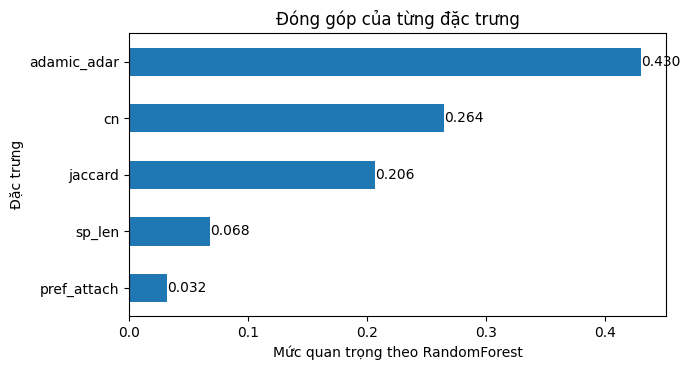

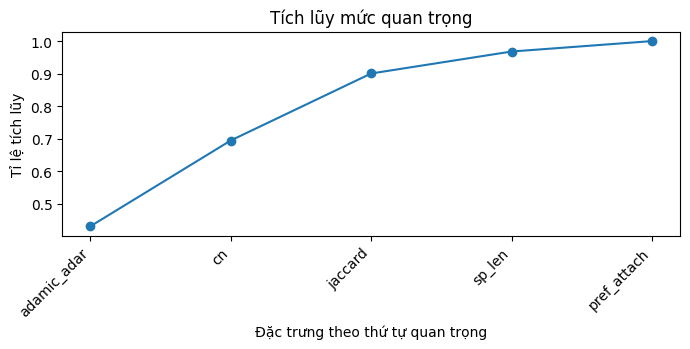

In [59]:


import matplotlib.pyplot as plt

# 1. Bar chart ngang để thấy đặc trưng quan trọng nhất nằm trên cùng
imp_sorted = imp.sort_values(ascending=True)  # tăng dần để vẽ barh đẹp
plt.figure(figsize=(7, 3.8))
imp_sorted.plot(kind="barh")
for i, v in enumerate(imp_sorted.values):
    plt.text(v, i, f"{v:.3f}", va="center", ha="left")
plt.title("Đóng góp của từng đặc trưng")
plt.xlabel("Mức quan trọng theo RandomForest")
plt.ylabel("Đặc trưng")
plt.tight_layout()
plt.show()

# 2. Đường tích lũy để thấy bao nhiêu đặc trưng chiếm X phần đóng góp
cum = imp.sort_values(ascending=False).cumsum()
cum = cum / cum.iloc[-1]
plt.figure(figsize=(7, 3.6))
plt.plot(range(len(cum)), cum.values, marker="o")
plt.xticks(range(len(cum)), cum.index, rotation=45, ha="right")
plt.title("Tích lũy mức quan trọng")
plt.xlabel("Đặc trưng theo thứ tự quan trọng")
plt.ylabel("Tỉ lệ tích lũy")
plt.tight_layout()
plt.show()


In [60]:
def candidates_by_distance(G: nx.Graph, u0: int, exact_dist=None, min_dist=None):
    """Ứng viên KHÔNG kết nối trực tiếp với u0, có đường đi và thoả khoảng cách."""
    nbrs = set(G.neighbors(u0))
    out = []
    # nhanh hơn: quét distances gần với single_source
    dists = nx.single_source_shortest_path_length(G, u0, cutoff=6)
    for v, d in dists.items():
        if v == u0 or v in nbrs: 
            continue
        if exact_dist is not None and d == exact_dist:
            out.append(v)
        elif min_dist is not None and d >= min_dist:
            out.append(v)
    return out

def recommend_for_candidates(u0: int, candidates, model, G_feat, topk=10):
    pairs = [(u0, v) for v in candidates]
    feats = features_for_pairs_table(G_feat, pairs)  # trích trên G_feat (đã tránh rò rỉ nếu tự tạo nhãn)
    probs = model.predict_proba(feats[["cn","jaccard","adamic_adar","pref_attach","sp_len"]])[:,1]
    feats["p"] = probs
    return feats.sort_values("p", ascending=False).head(topk).reset_index(drop=True)

u0 = NODE_TARGET

# Nhóm 1: dist=2 (bạn của bạn)
cand_d2 = candidates_by_distance(G, u0, exact_dist=2)
top_d2  = recommend_for_candidates(u0, cand_d2, rf, G_feat_graph, topk=TOPK)

# Nhóm 2: dist>=3 (bạn của bạn của bạn…)
cand_d3p = candidates_by_distance(G, u0, min_dist=3)
top_d3p  = recommend_for_candidates(u0, cand_d3p, rf, G_feat_graph, topk=TOPK)

print(f"#candidates dist=2 : {len(cand_d2)}")
print(f"#candidates dist≥3: {len(cand_d3p)}")

print("\nTop-10 (dist=2):")
for i, r in top_d2.iterrows():
    print(f"{i+1:>2}. v={int(r.v):<5} p={r.p:.3f}  CN={int(r.cn)}  J={r.jaccard:.4f}  AA={r.adamic_adar:.3f}  dist={int(r.sp_len)}")

print("\nTop-10 (dist≥3):")
for i, r in top_d3p.iterrows():
    print(f"{i+1:>2}. v={int(r.v):<5} p={r.p:.3f}  CN={int(r.cn)}  J={r.jaccard:.4f}  AA={r.adamic_adar:.3f}  dist={int(r.sp_len)}")


#candidates dist=2 : 1217
#candidates dist≥3: 2662

Top-10 (dist=2):
 1. v=545   p=0.997  CN=14  J=0.0828  AA=3.336  dist=2
 2. v=526   p=0.997  CN=11  J=0.0498  AA=2.448  dist=2
 3. v=458   p=0.997  CN=10  J=0.0629  AA=2.384  dist=2
 4. v=366   p=0.997  CN=28  J=0.1379  AA=6.619  dist=2
 5. v=527   p=0.997  CN=25  J=0.1562  AA=5.839  dist=2
 6. v=397   p=0.997  CN=11  J=0.0625  AA=2.487  dist=2
 7. v=402   p=0.997  CN=27  J=0.1598  AA=6.425  dist=2
 8. v=495   p=0.993  CN=10  J=0.0641  AA=2.483  dist=2
 9. v=479   p=0.993  CN=12  J=0.0723  AA=2.787  dist=2
10. v=493   p=0.993  CN=13  J=0.0734  AA=2.966  dist=2

Top-10 (dist≥3):
 1. v=256   p=0.227  CN=0  J=0.0000  AA=0.000  dist=99
 2. v=292   p=0.227  CN=0  J=0.0000  AA=0.000  dist=99
 3. v=3729  p=0.227  CN=0  J=0.0000  AA=0.000  dist=99
 4. v=892   p=0.227  CN=0  J=0.0000  AA=0.000  dist=99
 5. v=287   p=0.227  CN=0  J=0.0000  AA=0.000  dist=99
 6. v=3960  p=0.017  CN=0  J=0.0000  AA=0.000  dist=3
 7. v=2513  p=0.017  CN=0  J=0.000

[INFO] nodes: 2857, edges: 57005
[INFO] rec dist=2 tổng: 10 | tổng liên kết: 10


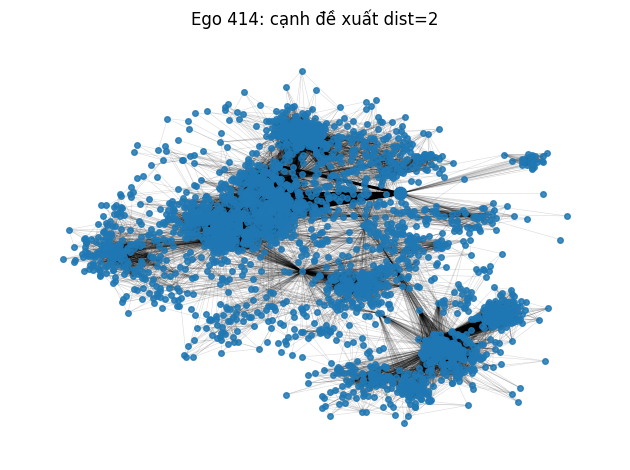

In [61]:
# ====== IMPORTS ======
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ====== THAM SỐ ======
radius = 3                 # bán kính ego để lấy lõi
# u0 = <NODE_TARGET>      # đảm bảo đã có trong môi trường

# ====== LẤY CẠNH ĐỀ XUẤT dist=2 ======
def pairs_from_df(df, ego):
    return [(int(ego), int(v)) for v in df["v"].tolist()]

rec_edges_d2 = pairs_from_df(top_d2, u0) if "top_d2" in globals() else []

# ====== CHỌN ĐỒ THỊ GỐC ======
base_G = G_feat_graph if "G_feat_graph" in globals() else G
if u0 not in base_G:
    raise ValueError(f"u0={u0} không nằm trong đồ thị.")

# ====== MỞ RỘNG SUBGRAPH ĐỂ CHỨA ĐỦ NODE CẦN VẼ ======
H_core = nx.ego_graph(base_G, u0, radius=radius)

nodes_needed = set(H_core.nodes())
for u, v in rec_edges_d2:
    if base_G.has_node(u) and base_G.has_node(v):
        nodes_needed.add(int(u)); nodes_needed.add(int(v))

H = base_G.subgraph(nodes_needed).copy()

# Chỉ vẽ cạnh đề xuất chưa tồn tại trong H để hình rõ ràng
def drop_existing(H, edgelist):
    out = []
    for u, v in edgelist:
        a, b = int(u), int(v)
        if not H.has_edge(a, b):
            out.append((a, b))
    return out

rec_edges_d2_new = drop_existing(H, rec_edges_d2)

print(f"[INFO] nodes: {H.number_of_nodes()}, edges: {H.number_of_edges()}")
print(f"[INFO] rec dist=2 tổng: {len(rec_edges_d2)} | tổng liên kết: {len(rec_edges_d2_new)}")

# ====== VẼ DUY NHẤT 1 HÌNH dist = 2 ======
pos = nx.spring_layout(H, seed=42)

# nền nhạt
nx.draw_networkx_edges(H, pos, edgelist=list(H.edges()), width=0.4, alpha=0.15)
nx.draw_networkx_nodes(H, pos, node_size=16, alpha=0.85)

# ego nổi bật
if H.has_node(u0):
    nx.draw_networkx_nodes(H, pos, nodelist=[u0], node_size=80)

# tô đậm các cạnh đề xuất dist=2 và các nút liên quan
if rec_edges_d2_new:
    nx.draw_networkx_edges(H, pos, edgelist=rec_edges_d2_new, width=2.2, style='-')
    rec_nodes_d2 = {n for e in rec_edges_d2_new for n in e}
    nx.draw_networkx_nodes(H, pos, nodelist=list(rec_nodes_d2), node_size=30)

plt.title(f"Ego {u0}: cạnh đề xuất dist=2")
plt.axis("off")
plt.tight_layout()
plt.show()

# ====== (tuỳ chọn) xuất bảng cho subgraph đang vẽ ======
# dist từ ego tính trên base_G để có giá trị cho mọi node reachable
# dist_map = nx.single_source_shortest_path_length(base_G, u0)
# nodes_df = pd.DataFrame({
#     "node": list(H.nodes()),
#     "degree_in_subgraph": [H.degree(n) for n in H.nodes()],
#     "dist_from_ego": [dist_map.get(n, None) for n in H.nodes()]
# })
# nodes_df.to_csv("ego_nodes_dist2_only.csv", index=False)


In [62]:
out_d2  = "/kaggle/working/recommendations_414_dist2.csv"
out_d3p = "/kaggle/working/recommendations_414_dist_ge3.csv"
top_d2.to_csv(out_d2, index=False)
top_d3p.to_csv(out_d3p, index=False)
print("Saved:", out_d2, "and", out_d3p)

# Bảng thống kê nhanh để so sánh p
def quick_stats(df, tag):
    return {
        "group": tag, "count": len(df),
        "p_mean": float(df["p"].mean()),
        "p_median": float(df["p"].median()),
        "p_min": float(df["p"].min()),
        "p_max": float(df["p"].max()),
    }

stats = pd.DataFrame([quick_stats(top_d2, "dist=2"),
                      quick_stats(top_d3p, "dist≥3")])
display(stats)


Saved: /kaggle/working/recommendations_414_dist2.csv and /kaggle/working/recommendations_414_dist_ge3.csv


,group,count,p_mean,p_median,p_min,p_max
0,dist=2,10,0.995667,0.996667,0.993333,0.996667
1,dist≥3,10,0.121930,0.121930,0.016667,0.227193
